#Importing Libraries

In [6]:
import os   #To access the files
import numpy as np
import librosa  #To handerl audio files
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Loading Dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

# Define paths
data_path = "/content/drive/My Drive/audio_speech_actors_01-24"

Mounted at /content/drive


#Extracting features and converting to numpy array

In [8]:
s=[]
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            y, sr = librosa.load(file_path, duration=3, offset=0.5, sr=None)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            s.append(mel_spec_db.shape[1])
s=np.array(s)
# Define a fixed size for the spectrograms
#FIXED_LENGTH =int(np.median(s))
FIXED_LENGTH=300
print(FIXED_LENGTH)

300


In [9]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Pad or truncate the spectrogram to ensure a fixed size
    if mel_spec_db.shape[1] < FIXED_LENGTH:
        # Pad with zeros if spectrogram is shorter
        pad_width = FIXED_LENGTH - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        # Truncate if spectrogram is longer
        mel_spec_db = mel_spec_db[:, :FIXED_LENGTH]

    return mel_spec_db

In [10]:
# Loading data
features, labels = [], []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion_label = file.split("-")[2]  # Extract label from filename
            features.append(extract_features(file_path))
            labels.append(emotion_label)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

print("Features shape:", features.shape)  # Expected shape: (num_samples, 128, FIXED_LENGTH)
print("Labels shape:", labels.shape)
print(labels)

Features shape: (1440, 128, 300)
Labels shape: (1440,)
['01' '01' '01' ... '08' '08' '08']


In [11]:
emotion=np.array(["Neutral","Calm","Happy","Sad","Angry","Fearful","Disgust","Surprised"])

In [12]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

#Generating Train and Test dataset

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = X_train / np.max(X_train)
X_val = X_val / np.max(X_val)
X_test = X_test / np.max(X_test)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.fit_transform(y_test)

In [14]:
print("X_train dtype:", X_train.dtype)
print("X_test dtype:", X_test.dtype)
print("y_train dtype:", y_train.dtype)
print("y_test dtype:", y_test.dtype)
print("X_val dtype:", X_val.dtype)
print("y_val dtype:", y_val.dtype)


X_train dtype: float32
X_test dtype: float32
y_train dtype: int64
y_test dtype: int64
X_val dtype: float32
y_val dtype: int64


In [ ]:
'''#CNN takes 4D input, So we add Channel dimension

X_train = X_train[..., np.newaxis]  # Add a channel dimension
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]'''

'#CNN takes 4D input, So we add Channel dimension\n\nX_train = X_train[..., np.newaxis]  # Add a channel dimension\nX_val = X_val[..., np.newaxis]\nX_test = X_test[..., np.newaxis]'

#Defining the Architecture of The Model

In [24]:
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf

# Initialize the Sequential Model
model = models.Sequential()

# 1st Convolutional Layer
model.add(layers.Conv1D(
    filters=128,
    kernel_size=5,
    padding='same',
    input_shape=(128, FIXED_LENGTH),
    activation='relu',
    kernel_regularizer=regularizers.l2(1e-4)
))
model.add(layers.BatchNormalization())  # Normalize layer outputs for stable training
model.add(layers.MaxPooling1D(pool_size=2))  # Reduce spatial dimension

# 2nd Convolutional Layer
model.add(layers.Conv1D(
    filters=256,
    kernel_size=3,
    padding='same',
    activation='relu',
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))  # Increase dropout to prevent overfitting
model.add(layers.MaxPooling1D(pool_size=2))

# 3rd Convolutional Layer
model.add(layers.Conv1D(
    filters=128,
    kernel_size=3,
    padding='same',
    activation='relu',
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
))
model.add(layers.BatchNormalization())

# 4th Convolutional Layer
model.add(layers.Conv1D(
    filters=128,
    kernel_size=3,  # Reduced kernel size for more localized patterns
    padding='same',
    activation='relu',
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Flatten for Dense Layers
model.add(layers.Flatten())

# Fully Connected Dense Layer
model.add(layers.Dense(
    units=64,  # Added hidden dense layer for better feature representation
    activation='relu',
    kernel_regularizer=regularizers.l2(1e-4)
))
model.add(layers.Dropout(0.4))  # Dropout for fully connected layer

# Output Layer
model.add(layers.Dense(
    units=8,  # Number of classes
    activation='softmax',
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)
))

# Compile the Model
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Model Summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 128, 128)            │         192,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 64, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 32, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 32, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 703,688 (2.68 MB)

 Trainable params: 702,408 (2.68 MB)

 Non-trainable params: 1,280 (5.00 KB)

#Training The Model

In [25]:
model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=80,batch_size=32)

Epoch 1/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.1650 - loss: 3.0816 - val_accuracy: 0.1042 - val_loss: 95.7029
Epoch 2/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2524 - loss: 2.1422 - val_accuracy: 0.1250 - val_loss: 52.9468
Epoch 3/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2487 - loss: 2.1136 - val_accuracy: 0.1181 - val_loss: 31.0726
Epoch 4/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2866 - loss: 2.0154 - val_accuracy: 0.1389 - val_loss: 8.7786
Epoch 5/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3235 - loss: 1.9189 - val_accuracy: 0.2569 - val_loss: 3.0242
Epoch 6/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3247 - loss: 1.8823 - val_accuracy: 0.4236 - val_loss: 1.8912
Epoch 7/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3452 - loss: 1.8492 - val_accuracy: 0.2500 - val_loss: 3.5250
Epoch 8/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3405 - loss: 1.8744 - val_accuracy: 0.2569 - va

In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4793 - loss: 2.9261 
Test Accuracy: 52.78%


**Generating Probablities**

In [27]:
probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


#Visualizing result

In [29]:
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(8),emotion,rotation=90)
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

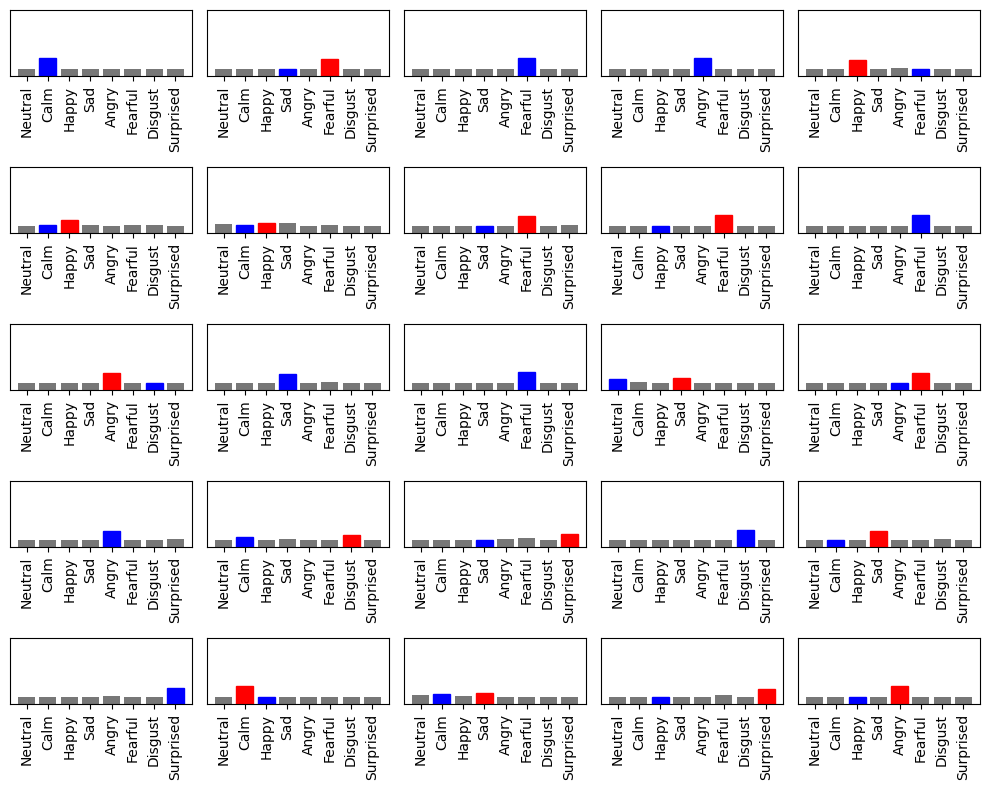

In [30]:
num_rows = 5
num_cols = 5
plt.figure(figsize=(10,8))
for i in range(num_rows*num_cols):
  plt.subplot(num_rows, num_cols, i+1)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()